In [1]:
# Initialize the notebook
import importlib
from pathlib import Path


def _check_import(package: str) -> str:
    try:
        importlib.import_module(package[0])
    except ImportError:
        return (
            f"{package[0]} not found on the system!\n"
            f"Please install {package[0]} by running:\n\n"
            f"    pip install {package[1] if len(package) > 1 else package[0]}\n\n"
        )
    else:
        return ""

messages = ""
for package in (("numpy",), ("yaml", "pyyaml"), ("oteapi", "oteapi-core"), ("otelib",), ("rdflib",), ("graphviz",), ("openpyxl",)):
    messages += _check_import(package)
if messages:
    raise ImportError(messages)

In [2]:
from pathlib import Path
# from s7.entitygen_simple import create_entity
from s7.models import create_config
from s7.entitygen import create_entity

xls_eff_config = create_config(Path(".").resolve() / 'inhibitor_conf.yml')

DataSourceEffEntity = create_entity(
    data_model=Path(".").resolve() / "efficiency.yaml",
    resource_config={
        "downloadUrl": (Path(".").resolve() / "Inhibitor_Data_Analysis_summary.xlsx").as_uri(),
        "mediaType": "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
        "configuration": xls_eff_config,
    },
)
eff_entity = DataSourceEffEntity()


### S7/DLite Data Model - Electrochemical Impedance Spectroscopy (EIS) Efficiency Data

In [3]:
import yaml

print("CAS #:", eff_entity.casNumber)
print("Impedance (24h) [log(Ohm)]:", eff_entity.impedance_log_24h, end="\n\n")

print(yaml.safe_dump(eff_entity.schema()))
eff_entity.schema()

CAS #: ['554-13-2', '554-13-2', '7447-41-8', '7447-41-8', '7447-41-8']
Impedance (24h) [log(Ohm)]: [5.00314131824638, 4.99955315940226, 4.11654541915057, 4.24085085066989, 4.40301509970376]

additionalProperties: false
description: Generic Data source entity
properties:
  casNumber:
    description: CAS number
    title: casNumber
    type: string
  impedance_log_24h:
    description: Impedance Log (24h)
    title: impedance_log_24h
    type: number
    x-unit: log(Ohm)
  runID:
    description: Experiment identification
    title: runID
    type: string
  sampleType:
    description: Molecule name
    title: sampleType
    type: string
title: DataSourceEntity
type: object



{'title': 'DataSourceEntity',
 'description': 'Generic Data source entity',
 'type': 'object',
 'properties': {'sampleType': {'title': 'sampleType',
   'description': 'Molecule name',
   'type': 'string'},
  'casNumber': {'title': 'casNumber',
   'description': 'CAS number',
   'type': 'string'},
  'runID': {'title': 'runID',
   'description': 'Experiment identification',
   'type': 'string'},
  'impedance_log_24h': {'title': 'impedance_log_24h',
   'description': 'Impedance Log (24h)',
   'type': 'number',
   'x-unit': 'log(Ohm)'}},
 'additionalProperties': False}

In [4]:
xls_lpr_config = create_config(Path(".").resolve() / 'LPR_conf.yml')

DataSourceLPREntity = create_entity(
    data_model=Path(".").resolve() / "lpr.yaml",
    resource_config={
        "downloadUrl": (Path(".").resolve() / "Inhibitor_Data_Analysis_summary.xlsx").as_uri(),
        "mediaType": "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
        "configuration": xls_lpr_config,
    },
)
lpr_entity = DataSourceLPREntity()

### S7/DLite Data Model - Linear Polarization Resistance (LPR) Efficiency Data

In [5]:
import yaml

print("CAS #:", lpr_entity.casNumber)
print("LPR 24h [Ohm]:", lpr_entity.lpr_24h, end="\n\n")

print(yaml.safe_dump(lpr_entity.schema()))

CAS #: ['554-13-2', '554-13-2', '554-13-2', '7447-41-8', '7447-41-8', '7447-41-8']
LPR 24h [Ohm]: [42146, 106409, 105467, 8425, 9119, 9649]

additionalProperties: false
description: Generic Data source entity
properties:
  casNumber:
    description: CAS number
    title: casNumber
    type: string
  lpr_24h:
    description: LPR (24h)
    title: lpr_24h
    type: integer
    x-unit: Ohm
  runID:
    description: Experiment identification
    title: runID
    type: string
  sampleType:
    description: Molecule name
    title: sampleType
    type: string
title: DataSourceEntity
type: object



Knowledge Base


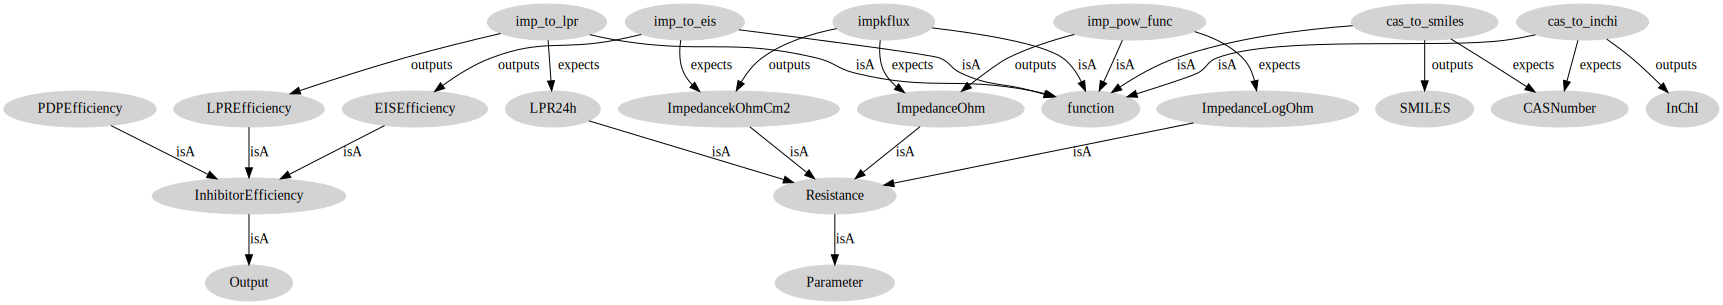

Knowledge Base + mapping


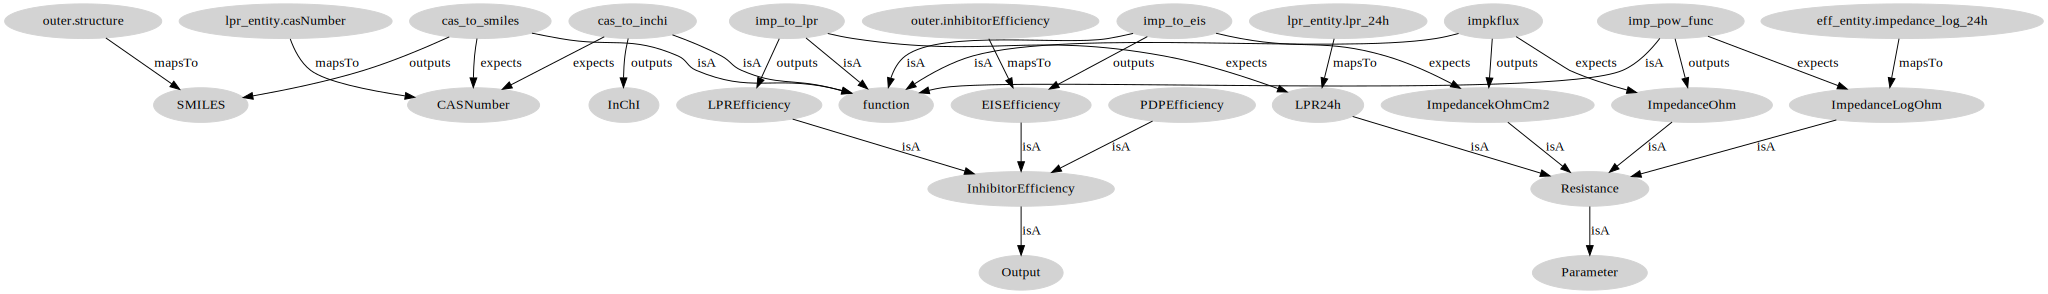

Knowledge Base + mapping + derived (local) functions


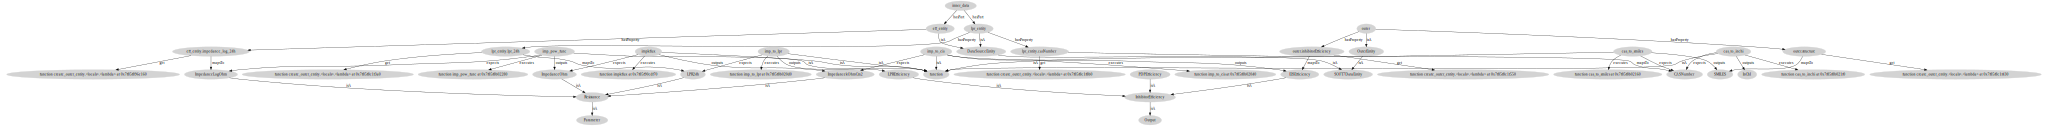

In [11]:
# from s7.outer_entitygen_simple import create_outer_entity
from s7.outer_entitygen_multi import create_outer_entity

GetEfficiency = create_outer_entity(
    data_model=Path(".").resolve() / "ai_model.yaml",
    # inner_entity=lpr_entity,  # lpr_24h
    # inner_entity=eff_entity,  # impedance_log_24h
    inner_entities={
        "eff_entity": eff_entity,
        "lpr_entity": lpr_entity,
    },
    mapping=[
        # What we want
        # ("outer.structure", "mapsTo", "InChI"),
        ("outer.structure", "mapsTo", "SMILES"),
        # ("outer.inhibitorEfficiency", "mapsTo", "LPREfficiency"),
        ("outer.inhibitorEfficiency", "mapsTo", "EISEfficiency"),

        # What we got
        # ("eff_entity.casNumber", "mapsTo", "CASNumber"),
        ("lpr_entity.casNumber", "mapsTo", "CASNumber"),
        ("lpr_entity.lpr_24h", "mapsTo", "LPR24h"),
        ("eff_entity.impedance_log_24h", "mapsTo", "ImpedanceLogOhm"),

        # What we got - singly
        # ("inner.casNumber", "mapsTo", "CASNumber"),
        # ("inner.lpr_24h", "mapsTo", "LPR24h"),
        # ("inner.impedance_log_24h", "mapsTo", "ImpedanceLogOhm"),
    ],
)
outer_entity = GetEfficiency()
# print("Log10 calculation of inner entity 'impedance_ohm_24h':", list(log10(entity.impedance_ohm_24h)))
# print("Double calculation of inner entity 'impedance_ohm_24h':", [_ * 2 for _ in entity.impedance_ohm_24h])
# print("Half calculation of inner entity 'impedance_log_24h':", [_ / 2 for _ in entity.impedance_log_24h])




### S7/DLite Data Model

In [12]:
import yaml

print(yaml.safe_dump(outer_entity.schema()))

additionalProperties: false
description: Generic Data source entity
properties:
  inhibitorEfficiency:
    description: EIS 24h
    title: inhibitorEfficiency
    type: number
  structure:
    description: Atomic structure
    title: structure
    type: string
title: OuterEntity
type: object



### Inhibitor Efficiency

In [13]:
print("Outer entity parameter 'inhibitorEfficiency':", outer_entity.inhibitorEfficiency, end="\n\n")
# print("Inner entity parameter 'impedance_log_24h':", eff_entity.impedance_log_24h, end="\n\n")
print("Inner entity parameter 'lpr_24h':", lpr_entity.lpr_24h, end="\n\n")

[['outer.inhibitorEfficiency', 'EISEfficiency', 'imp_to_eis', 'ImpedancekOhmCm2', 'impkflux', 'ImpedanceOhm', 'imp_pow_func', 'ImpedanceLogOhm', 'eff_entity.impedance_log_24h', 'eff_entity', 'inner_data']]
Graph traversed! Path: outer.inhibitorEfficiency -> EISEfficiency -> imp_to_eis -> ImpedancekOhmCm2 -> impkflux -> ImpedanceOhm -> imp_pow_func -> ImpedanceLogOhm -> eff_entity.impedance_log_24h -> eff_entity -> inner_data
Outer entity parameter 'inhibitorEfficiency': [82.8480791047297, 82.70578220798093, -32.10177835991131, 0.7790838781530307, 31.697125120830314]

Inner entity parameter 'lpr_24h': [42146, 106409, 105467, 8425, 9119, 9649]



### Structure

In [14]:
print("Outer entity parameter 'structure':", outer_entity.structure, end="\n\n")
print("Inner entity parameter 'casNumber'", lpr_entity.casNumber, end="\n\n")

[['outer.structure', 'SMILES', 'cas_to_smiles', 'CASNumber', 'lpr_entity.casNumber', 'lpr_entity', 'inner_data']]
Graph traversed! Path: outer.structure -> SMILES -> cas_to_smiles -> CASNumber -> lpr_entity.casNumber -> lpr_entity -> inner_data
Outer entity parameter 'structure': ['[Li+].[Li+].[O-]C([O-])=O', '[Li+].[Li+].[O-]C([O-])=O', '[Li+].[Li+].[O-]C([O-])=O', '[Li+].[Cl-]', '[Li+].[Cl-]', '[Li+].[Cl-]']

Inner entity parameter 'casNumber' ['554-13-2', '554-13-2', '554-13-2', '7447-41-8', '7447-41-8', '7447-41-8']



In [10]:
from s7.graph import Graph

graph_mapping = [
    # ("properties.SMILES", "mapsTo", "SMILES"),
    # ("properties.inhibitorEfficiency", "mapsTo", "EISEfficiency"),
    # ("data.casNumber", "mapsTo", "CAS#"),
    # ("data.inhibitorEfficiency", "mapsTo", "ImpedanceOhm"),
    ("imp_to_flux", "expects", "ImpedanceOhm"),
    ("imp_to_flux", "outputs", "EISEfficiency"),
    ("imp_to_flux", "isA", "function"),
    ("ImpedanceOhm", "isA", "Resistance"),
    ("ImpedanceLogOhm", "isA", "Resistance"),
    ("EISEfficiency", "isA", "InhibitorEfficiency"),
    ("LPREfficiency", "isA", "InhibitorEfficiency"),
    ("Resistance", "isA", "Parameter"),
    ("InhibitorEfficiency", "isA", "Output"),
    # ("function", "hasMethod", "execute"),
    ("cas_to_smiles", "isA", "function"),
    ("cas_to_smiles", "expects", "CAS#"),
    ("cas_to_smiles", "outputs", "SMILES"),

    # Generated in `create_outer_entity()`:
    # ("imp_to_flux", "executes", lambda: ...)
    # ("cas_to_smiles", "executes", lambda: ...)
]
graph = Graph(graph_mapping)
graph.plot()
for _ in graph.recur_find("EISEfficiency", "ImpedanceOhm"):
    print(_)
# graph.path("SMILES", "CAS#")

['EISEfficiency', 'imp_to_flux', 'ImpedanceOhm']
